In [1]:
from collections import defaultdict
from iteration_utilities import deepflatten
from matplotlib.pylab import figure, imshow, show
from pandas import read_csv
from seaborn import heatmap, scatterplot, color_palette
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import TFAutoModel, AutoModel, AutoTokenizer
import tensorflow
import sys
import torch

# m = TFAutoModel.from_pretrained('bert-base-cased')
# m = TFAutoModel.from_pretrained('emanjavacas/MacBERTh', from_pt=True)
m = AutoModel.from_pretrained('emanjavacas/MacBERTh')
m.eval()
tok = AutoTokenizer.from_pretrained('emanjavacas/MacBERTh')

data = read_csv('./data/thesis-utf8-data.csv')

a, b, c = zip(*data[['Context before', 'Query term', 'Context after']].values)

sents, keywords = [], []
for a1, b1, c1 in zip(a, b, c):
    sents.append(a1 + ' ' + b1 + ' '+ c1)
    keywords.append(b1)
    
with torch.no_grad():
    ids = tok(list(sents), return_tensors='pt', padding=True)
    output = m(**ids)

# ids = tok(list(sents), return_tensors='tf', padding=True)
# output = m(ids)

Some weights of the model checkpoint at emanjavacas/MacBERTh were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def get_token_indexes(ids, tokenizer, prefix='##'):
    output = defaultdict(list)
    special = set(tokenizer.special_tokens_map.values())
    subwords = tokenizer.convert_ids_to_tokens(ids)
    ids, word = [], ''
    for idx, subword in enumerate(subwords):
        if subword in special:
            continue
        if subword.startswith(prefix):
            word += subword[len(prefix):]
            ids.append(idx)
        else:
            if word:
                output[word].append(ids)
            ids, word = [idx], subword
    if word:
        output[word].append(ids)
    return output

target = []
for idx, keyword in enumerate(keywords):
    mapping = get_token_indexes(ids.input_ids[idx], tok)
    if len(mapping[keyword]) > 1:
        target.append(mapping[keyword][0])
    else :
        target.append(mapping[keyword])
target = list(deepflatten(target))

# np_arr = output['last_hidden_state'].numpy()
np_arr = output['last_hidden_state'].cpu().detach().numpy()
embeddings = []
for i in list(range(len(np_arr))):
    embeddings.append(np_arr[i][target[i]].tolist())

/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


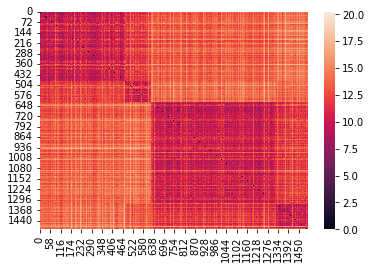

<AxesSubplot:>

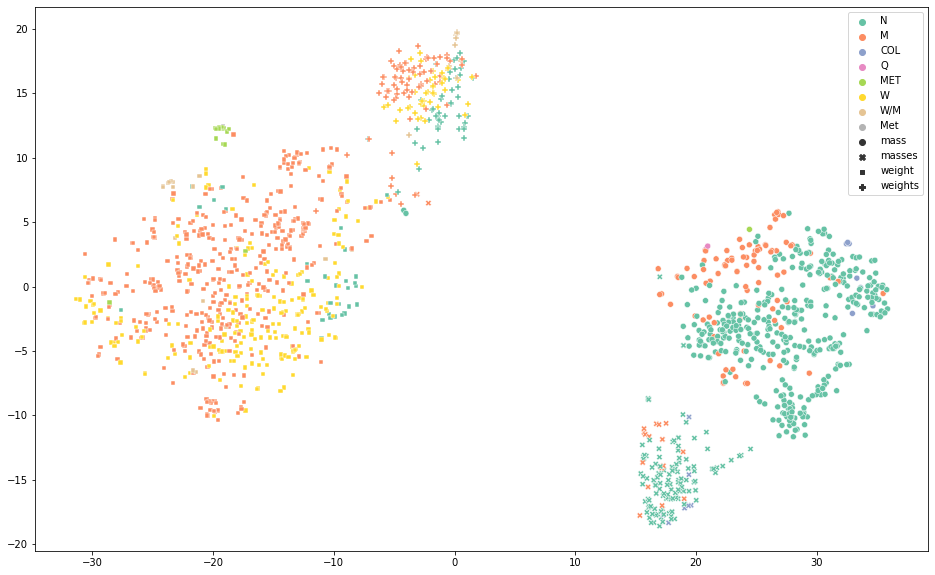

In [7]:
pca_embeddings = PCA(n_components=50).fit_transform(embeddings)
tsne_embeddings = TSNE(perplexity=100, init='pca', random_state=153).fit_transform(pca_embeddings)

distance = pairwise_distances(embeddings)
ax = heatmap(distance)
show()

senses = list(data['Sense'])
# usage = list(data['Query term'][:250]) + list(data['Query term'][750:1000])
usage = list(data['Query term'])

figure(figsize=(16,10))
scatterplot(
    x=tsne_embeddings[:,0], y=tsne_embeddings[:,1],
    style=usage,
    hue=senses,
    palette=color_palette('Set2', len(set(senses))),
    legend="full",
)